In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import glob
import sys
import h3

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
import geopandas as gpd
import seaborn as sns
# use the husl color palette for age
colorls = sns.color_palette("husl", 3)
# plot the color
# convert to rgb color
color_ls_rgb = [(int(x[0]*255), int(x[1]*255), int(x[2]*255)) for x in colorls]

In [146]:
ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
version = 2
FOLDER_TO_SAVE = "{ROOTFOLDER}/_transformed/age_gender_v{version}/{cityabbr}"
FILE_TO_SAVE = "{ROOTFOLDER}/_transformed/age_gender_v{version}/{cityabbr}/n={part}_objects.parquet"
# FILE_TO_SAVE = "{ROOTFOLDER}/_transformed/age_gender/{cityabbr}/n={part}_objects.parquet"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
PATH_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"
FILE_TO_EXPORT = "{ROOTFOLDER}/_curated/c_age_gender_v{version}/{cityabbr}.parquet"
FOLDER_TO_EXP = f"{ROOTFOLDER}/_curated/c_age_gender_v{version}"
if not os.path.exists(FOLDER_TO_EXP):
    os.makedirs(FOLDER_TO_EXP)

In [129]:
v2_folder = f"{ROOTFOLDER}/_transformed/age_gender_v2"
FOLDER_TO_EXP = v2_folder

In [122]:
v2_files = os.listdir(v2_folder)
v3_files = os.listdir(f"{ROOTFOLDER}/_transformed/age_gender_v3")
# check the missing file from v3
missing_files = [x for x in v3_files if x not in v2_files]
missing_files

['montreal']

In [150]:

object_age_dict = {
                    'female18-60':'18-60', 
                'male18-60':'18-60', 
                'male-60':'60+', 
                'male-18':'18-', 
                'female-60':'60+',
                'female-18':'18-'
                }

def get_hex_basics(city_abbr, res):
    # read all object files and concat them into one df
    df_pano = pd.read_csv(PANO_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
    df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
    # only keep the panoid that has a path
    df_pano_inner = df_pano[
        df_pano["panoid"].isin(df_path["panoid"].unique())
    ].reset_index(drop=True)
    print(df_pano_inner.shape[0], "out of ", df_pano.shape[0], "panoids have path")
    df_pano_inner["hex_id"] = df_pano_inner.apply(
        lambda x: h3.geo_to_h3(x["lat"], x["lon"], res), axis=1
    )

    # keep these hex
    df_all_keep = df_pano_inner[(df_pano_inner["year"] >= 2014)
    ].reset_index(drop=True)
    print(df_all_keep.shape[0], "panoids are kept")
    # assign the year_group; skip for now
    
    # get number of panoid per hex per year
    df_all_keep_hex = (
        df_all_keep.groupby(["hex_id", "year"])["panoid"]
        .nunique()
        .reset_index(name="panoid_n")
    )
    return df_all_keep_hex, df_all_keep


def load_results(cityabbr):
    print("Now load version 2 results")
    df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr, version = version))
    df_path['img'] = df_path['path'].apply(lambda x: x.split("/")[-1])
    
    # process the prediction results
    objfiles = glob.glob(
        FOLDER_TO_SAVE.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr, version = version) + "/*.parquet"
    )
    if len(objfiles) == 0:
        print("No object files found for", cityabbr)
    df = pd.concat([pd.read_parquet(f) for f in objfiles])
    df_path = df_path.merge(df, on='img', how='inner')
    return df,df_path
    
def get_confidence(df, conf):
    df_con = df[df['confidence']>=conf].reset_index(drop=True)
    df_con['object_name'] = df_con['object_name'].apply(lambda x: x.lower())
    df_con['gender'] = df_con['object_name'].apply(lambda x: "female" if "female" in x.lower() else "male")
    df_con['age'] = df_con['object_name'].apply(lambda x: object_age_dict[x.lower()] if x.lower() in object_age_dict else "unknown")
    # find an image with most male-60
    df_summary = df_con.groupby(['img','gender', 'age']).size().reset_index().pivot(
        index='img', columns = ['gender', 'age'], values=0
    ).fillna(0)
    df_summary.columns = ['_'.join(x) for x in df_summary.columns]
    df_summary['pedestrian_count'] = df_summary.sum(axis=1)
    df_summary = df_summary.reset_index()
    df_summary['panoid'] = df_summary['img'].apply(lambda x: x[:22])
    df_summary_pano = df_summary.groupby(['panoid']).sum().reset_index()
    return df_summary, df_summary_pano

def get_result(city):
    cityabbr = city.lower().replace(" ", "")
    df, df_path = load_results(cityabbr)
    alldf = []
    for res in [8,9]:
        for conf in [0.2,0.5, 0.7, 0.8]:
            df_summary, df_summary_pano = get_confidence(df, conf)
            df_all_keep_hex, df_all_keep = get_hex_basics(cityabbr, res)
            df_summary_merged = df_summary_pano.merge(df_all_keep, on='panoid', how='inner')
            df_summary_merged['male_total'] = df_summary_merged[['male_18-60', 'male_60+','male_18-']].sum(axis=1)
            df_summary_merged['female_total'] = df_summary_merged[['female_18-60', 'female_60+','female_18-']].sum(axis=1)
            df_summary_merged['male_ratio'] = df_summary_merged['male_total']/df_summary_merged['pedestrian_count']
            df_summary_merged['female_ratio'] = df_summary_merged['female_total']/df_summary_merged['pedestrian_count']
            df_summary_hex = df_summary_merged.groupby(['hex_id', 'year'])[['male_18-60', 'male_60+', 'female_60+', 'female_18-60',
                'male_18-', 'female_18-','pedestrian_count']].sum().reset_index()
            df_summary_hex_pano = df_summary_merged.groupby(['hex_id','year']).agg({'panoid':'nunique'}).reset_index()
            df_summary_hex_pano.rename(columns={'panoid':'panoid_n_with_person'}, inplace=True)

            df_summary_final = df_all_keep_hex.merge(
                df_summary_hex, on=['hex_id', 'year'], how='left'
            ).merge(
                df_summary_hex_pano, on=['hex_id','year'], how='left'
            ).fillna(0)
            df_summary_final['res'] = res
            df_summary_final['conf'] = conf
            alldf.append(df_summary_final)
    alldf = pd.concat(alldf).reset_index(drop=True)
    # alldf.to_parquet(FILE_TO_EXPORT.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr, version = version), index=False)
    return alldf

In [140]:
city = "Dhaka"
cityabbr = city.lower().replace(" ", "")
df, df_path = load_results(cityabbr)

In [132]:
import gc
gc.collect()

632

In [133]:
df_summary, df_summary_pano = get_confidence(df, 0.5)
final_summary = df_summary_pano.sum().reset_index()
final_summary

,index,0
0,panoid,--0VhWsO9L2Zzuzf7FMfJA--KLxrER_JiEqUbjL-mfqQ-0...
1,img,--0VhWsO9L2Zzuzf7FMfJA_0.jpg--KLxrER_JiEqUbjL-...
2,female_unknown,5199.0
3,male_unknown,10454.0
4,pedestrian_count,15653.0


In [124]:
df_summary, df_summary_pano = get_confidence(df, 0.5)
final_summary = df_summary_pano.sum().reset_index()
final_summary

,gender,0
0,panoid,--0VhWsO9L2Zzuzf7FMfJA--KLxrER_JiEqUbjL-mfqQ-0...
1,img,--0VhWsO9L2Zzuzf7FMfJA_0.jpg--KLxrER_JiEqUbjL-...
2,female,5199.0
3,male,10454.0
4,pedestrian_count,15653.0


In [7]:

def get_hex_basics(city_abbr, res):
    # read all object files and concat them into one df
    df_pano = pd.read_csv(PANO_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
    df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
    # only keep the panoid that has a path
    df_pano_inner = df_pano[
        df_pano["panoid"].isin(df_path["panoid"].unique())
    ].reset_index(drop=True)
    # print(df_pano_inner.shape[0], "out of ", df_pano.shape[0], "panoids have path")
    df_pano_inner["hex_id"] = df_pano_inner.apply(
        lambda x: h3.geo_to_h3(x["lat"], x["lon"], res), axis=1
    )

    # keep these hex
    df_all_keep = df_pano_inner[(df_pano_inner["year"] >= 2014)
    ].reset_index(drop=True)
    print(df_all_keep.shape[0], "panoids are kept")
    # assign the year_group; skip for now
    
    # get number of panoid per hex per year
    df_all_keep_hex = (
        df_all_keep.groupby(["hex_id", "year"])["panoid"]
        .nunique()
        .reset_index(name="panoid_n")
    )
    return df_all_keep_hex, df_all_keep


def load_results(cityabbr):
    
    df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr))
    df_path['img'] = df_path['path'].apply(lambda x: x.split("/")[-1])
    
    # process the prediction results
    objfiles = glob.glob(
        FOLDER_TO_SAVE.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr) + "/*.parquet"
    )
    if len(objfiles) == 0:
        print("No object files found for", cityabbr)
        return pd.DataFrame(), df_path
    df = pd.concat([pd.read_parquet(f) for f in objfiles])
    return df,df_path
    
def get_confidence(df, conf):
    df_con = df[df['confidence']>=conf].reset_index(drop=True)
    df_con['object_name'] = df_con['object_name'].apply(lambda x: x.lower())
    df_con['gender'] = df_con['object_name'].apply(lambda x: "female" if "female" in x.lower() else "male")
    # df_con['age'] = df_con['object_name'].apply(lambda x: object_age_dict[x.lower()] if x.lower() in object_age_dict else "unknown")
     # this version does not care about age
    # find an image with most male-60
    df_summary = df_con.groupby(['img','gender']).size().reset_index().pivot(
        index='img', columns = ['gender'], values=0
    ).fillna(0)
    # df_summary.columns = ['_'.join(x) for x in df_summary.columns]
    df_summary['pedestrian_count'] = df_summary.sum(axis=1)
    df_summary = df_summary.reset_index()
    df_summary['panoid'] = df_summary['img'].apply(lambda x: x[:22])
    
    df_summary_pano = df_summary.groupby(['panoid']).sum().reset_index()
    # add a step to calculate the image-level average
    return df_summary, df_summary_pano

def get_result(city):
    cityabbr = city.lower().replace(" ", "")
    # check if the export exist, then skip:
    file_export = FILE_TO_EXPORT.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr)
    # if os.path.exists(file_export):
    #     print(f"city {city} already exists")
        # return None
    df, df_path = load_results(cityabbr)
    if df.shape[0] == 0:
        print(f"city {city} has no data")
        return None
    alldf = []
    for res in [8,9]:
        df_all_keep_hex, df_all_keep = get_hex_basics(cityabbr, res)
        for conf in [0.2, 0.5, 0.7, 0.8]:
            df_summary, df_summary_pano = get_confidence(df, conf)
            df_summary_merged = df_summary_pano.merge(df_all_keep, on='panoid', how='inner')
            male_stand = ['male']
            female_stand = ['female']
            
            male_export = [x for x in male_stand if x in df_summary_merged.columns]
            female_export = [x for x in female_stand if x in df_summary_merged.columns]
            
            df_summary_merged['male_total'] = df_summary_merged[male_export].sum(axis=1)
            df_summary_merged['female_total'] = df_summary_merged[female_export].sum(axis=1)
            df_summary_merged['male_ratio'] = df_summary_merged['male_total']/df_summary_merged['pedestrian_count']
            df_summary_merged['female_ratio'] = df_summary_merged['female_total']/df_summary_merged['pedestrian_count']
            
            standard_cols = ['male', 'female','pedestrian_count']
            cols_to_export = [x for x in standard_cols if x in df_summary_merged.columns]
            
            df_summary_hex = df_summary_merged.groupby(['hex_id', 'year'])[cols_to_export].sum().reset_index()
            df_summary_hex_mean = df_summary_merged.groupby(['hex_id', 'year']).agg({
                'male_ratio':'mean',
                'female_ratio':'mean'
            }).reset_index().rename(columns={'male_ratio':'male_ratio_img_mean',
                                             'female_ratio':'female_ratio_img_mean'} 
                                             ) # this is the average among images with at least one person
            
            df_summary_hex_pano = df_summary_merged.groupby(['hex_id','year']).agg({'panoid':'nunique'}).reset_index()
            df_summary_hex_pano.rename(columns={'panoid':'panoid_n_with_person'}, inplace=True)

            df_summary_final = df_all_keep_hex.merge(
                df_summary_hex, on=['hex_id', 'year'], how='left'
            ).merge(
                df_summary_hex_pano, on=['hex_id','year'], how='left'
            ).fillna(0)\
                .merge(
                df_summary_hex_mean, on=['hex_id', 'year'], how='left'
                )
            df_summary_final['res'] = res
            df_summary_final['conf'] = conf
            alldf.append(df_summary_final)
    alldf = pd.concat(alldf).reset_index(drop=True)
    alldf.to_parquet(FILE_TO_EXPORT.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr), index=False)
    print(f"city {city} done")
    return alldf

In [107]:
city = "Montreal"
cityabbr = city.lower().replace(" ", "")
df, df_path = load_results(cityabbr)
df_summary, df_summary_pano = get_confidence(df, 0.5)

In [99]:

alldf = get_result(city)

37503 panoids are kept
37503 panoids are kept
city Accra done


# Visualize the example for validation

In [125]:
df['panoid'] = df['img'].apply(lambda x: x[:22])

In [126]:
# sort_vari = 'male_60+'
sort_vari = "female"
sample_img = df_summary.sort_values(sort_vari, ascending=False)['img'].values[300]
print(sample_img)
# find the image path
df_path_sel = df_path[df_path['img']==sample_img].reset_index(drop=True)
print(df_path_sel['path'].values[0])

Fo0ziSWFjINpFvtCtA9pFA_90.jpg
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/montreal/img_rgb/e_1/6/8/Fo0ziSWFjINpFvtCtA9pFA_90.jpg


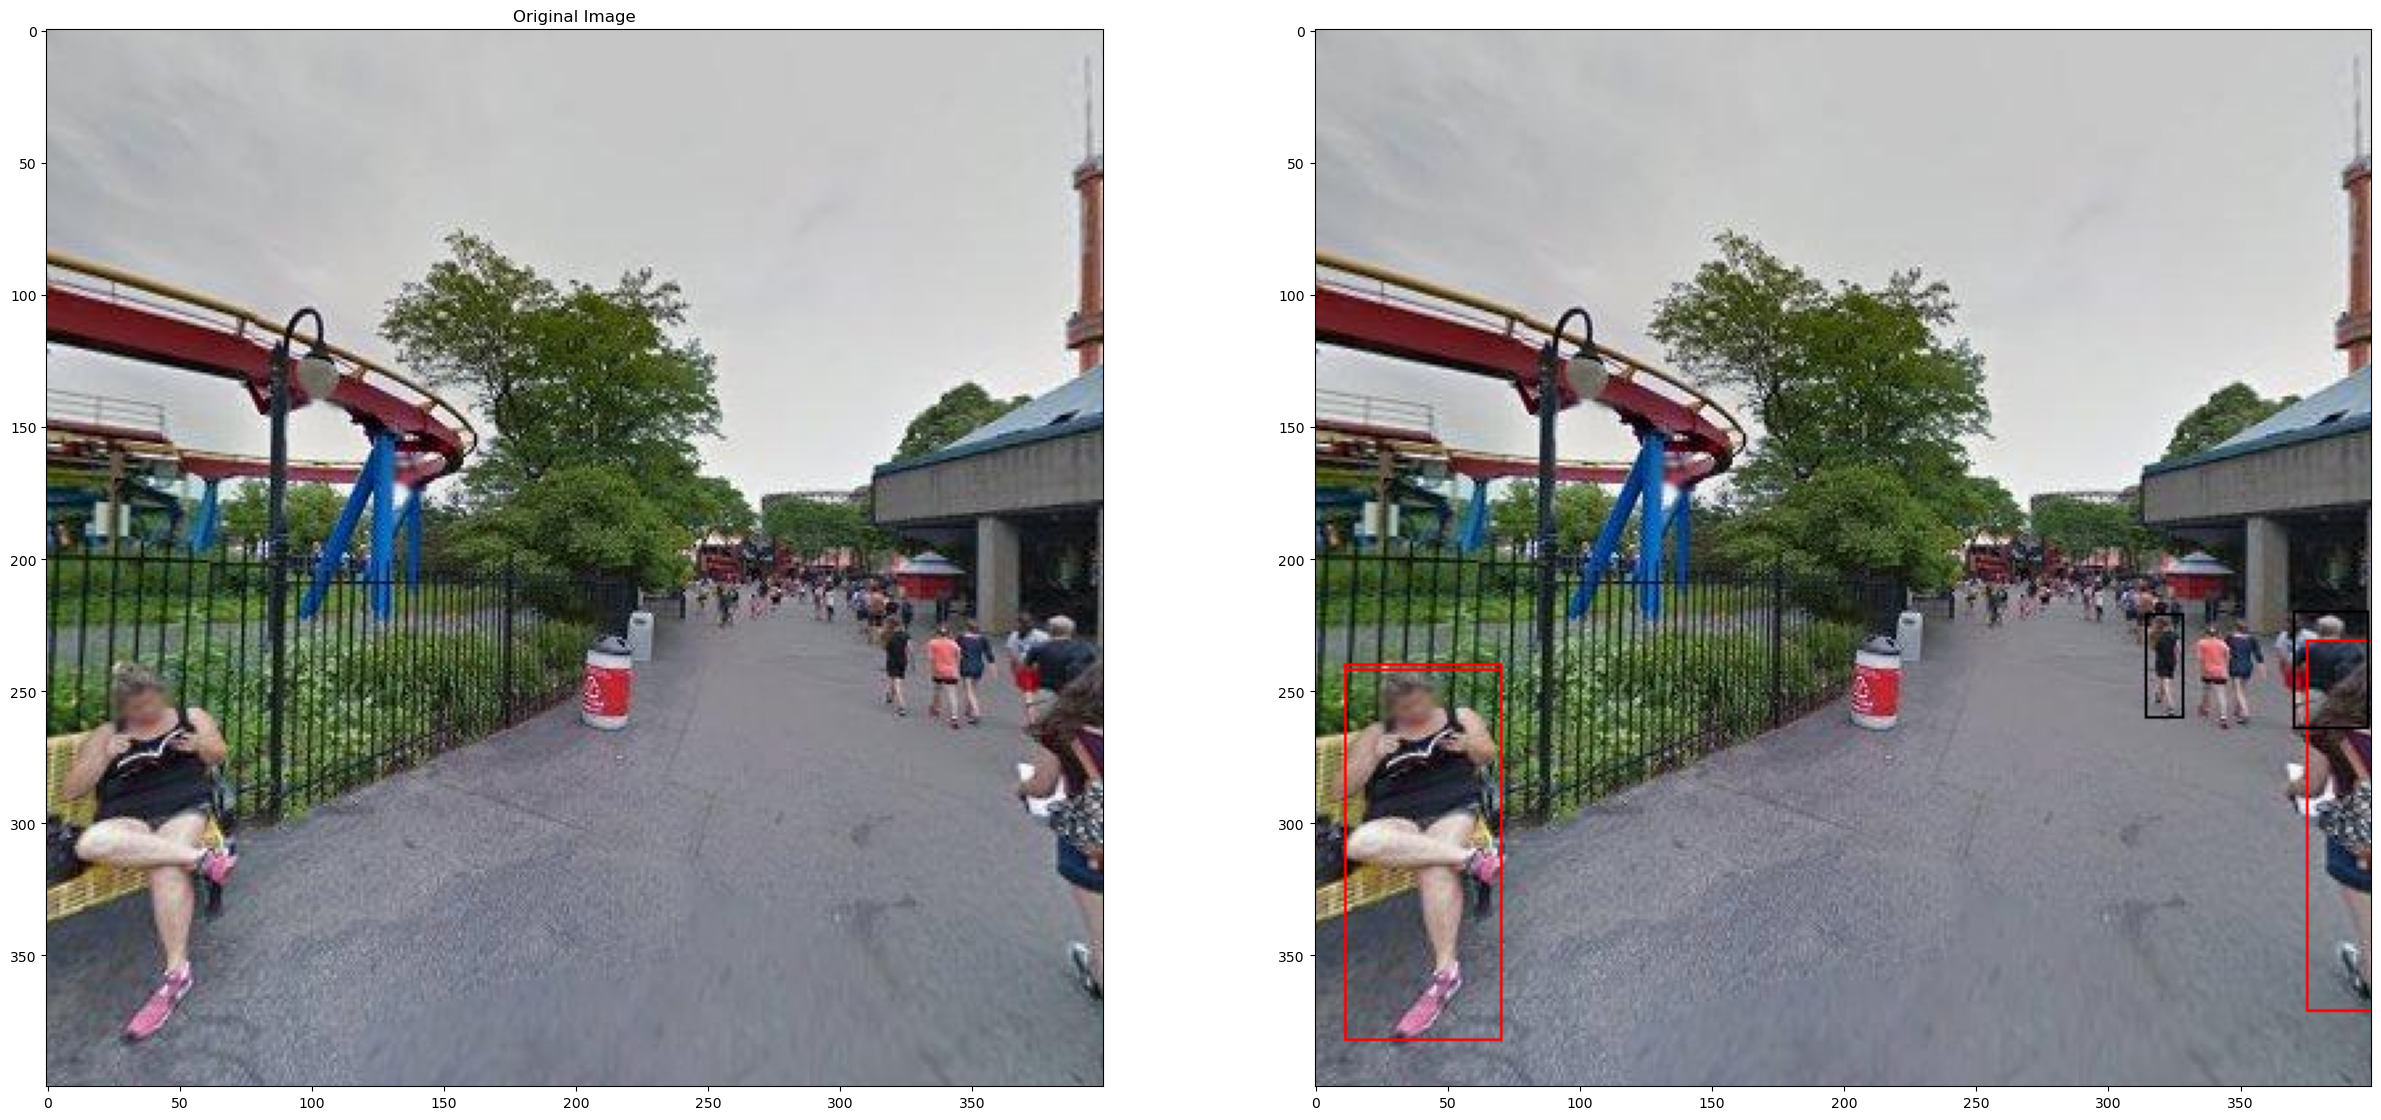

In [127]:
import cv2
import matplotlib.pyplot as plt
img_base = cv2.imread(df_path_sel['path'].values[0])
img_rgb = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
predictions = df[df['img']==sample_img].reset_index(drop = True)
for pred in predictions.iterrows():
    pred = pred[1]
    x1, y1, x2, y2 = pred['x1'], pred['y1'], pred['x2'], pred['y2']
    # if pred['gender']=='female':
    if pred['object_name']==sort_vari:
        cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 1) # red
    else:
        cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 1) # black
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
ax[0].imshow(cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[1].imshow(img_rgb)

# Resample additional images for labeling

In [143]:
SAMPLE_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_human_attr/c_cross_sectional/_sample_img"
FINISHED = os.listdir(SAMPLE_FOLDER)
print("Finished", len(FINISHED))
# check remaining
ALL_CITY = os.listdir(f"{ROOTFOLDER}/_transformed/age_gender_v{version}")
SOURCE_FOLDER = FOLDER_TO_EXP.format(ROOTFOLDER=ROOTFOLDER, version = version)
remain = [x for x in ALL_CITY if x not in FINISHED]

Finished 110


In [154]:
import shutil
def generate_sample(city):
    city_abbr = city.lower().replace(" ", "")
    df, df_path = load_results(city_abbr)
    if df.shape[0] == 0:
        print(f"city {city} has no data")
        return None

    df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
    df_path['img'] = df_path['path'].apply(lambda x: x.split("/")[-1])
    df['panoid'] = df['img'].apply(lambda x: x[:22])
    vari_sel = ['Male18-60', 'male-18', 'female18-60', 'Male-60', 'female-18',
       'female-60']
    img_folder = f'/lustre1/g/geog_pyloo/05_timemachine/_curated/c_human_attr/c_cross_sectional/_sample_img/{city_abbr}'
    for folder in [img_folder]:
        if not os.path.exists(folder):
            os.makedirs(folder)
    for var in vari_sel:
        gendersummary = df.groupby(['img','object_name']).size().reset_index().rename(columns={0:'count'})\
            .pivot(index='img', columns='object_name', values='count').reset_index().fillna(0).sort_values(var, ascending=False)
        sel_random = gendersummary.head(15)
        path_sel = df_path[df_path['img'].isin(sel_random['img'])].reset_index(drop = True)
        for i in range(path_sel.shape[0]):
            shutil.copy(path_sel.loc[i, 'path'], os.path.join(img_folder, path_sel.loc[i, 'img']))

In [155]:
# read the version 2 prediction. pick the top 90 images per city for the remaining cities
for city in tqdm(remain):
    print(city)
    generate_sample(city)

  0%|          | 0/17 [00:00<?, ?it/s]

nagoya
Now load version 2 results


  6%|▌         | 1/17 [00:50<13:26, 50.43s/it]

fukuoka
Now load version 2 results


 12%|█▏        | 2/17 [01:10<08:08, 32.59s/it]

palmas
Now load version 2 results


 18%|█▊        | 3/17 [01:17<04:55, 21.11s/it]

rome
Now load version 2 results


 24%|██▎       | 4/17 [01:33<04:07, 19.03s/it]

curitiba
Now load version 2 results


 29%|██▉       | 5/17 [01:45<03:17, 16.43s/it]

nairobi
Now load version 2 results


 35%|███▌      | 6/17 [02:02<03:02, 16.55s/it]

gaborone
Now load version 2 results


 41%|████      | 7/17 [02:11<02:19, 13.97s/it]

florianopolis
Now load version 2 results


 47%|████▋     | 8/17 [02:20<01:52, 12.50s/it]

jequie
Now load version 2 results


 53%|█████▎    | 9/17 [02:26<01:24, 10.52s/it]

kaunas
Now load version 2 results


 59%|█████▉    | 10/17 [02:33<01:06,  9.46s/it]

okayama
Now load version 2 results


 65%|██████▍   | 11/17 [02:49<01:08, 11.46s/it]

kualalumpur
Now load version 2 results


 71%|███████   | 12/17 [02:55<00:48,  9.73s/it]

riodejaneiro
Now load version 2 results


 76%|███████▋  | 13/17 [04:15<02:04, 31.04s/it]

victoria
Now load version 2 results


 82%|████████▏ | 14/17 [04:19<01:08, 23.00s/it]

ilheus
Now load version 2 results


 88%|████████▊ | 15/17 [04:27<00:36, 18.37s/it]

milan
Now load version 2 results


 94%|█████████▍| 16/17 [04:36<00:15, 15.46s/it]

yamaguchi
Now load version 2 results


100%|██████████| 17/17 [04:46<00:00, 16.87s/it]
